In [32]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import compute_mean_square_error, formatter
from generate_inputs import RUNS, A0_VALUES, DEFAULT_TIME, DEFAULT_DT

In [33]:
def calculate_q(exits_data, steady_state, min=0.0, max=2.0, tries=100):
    filtered_data = exits_data[exits_data.index > steady_state]

    x_values = filtered_data.index
    y_values = filtered_data

    x0 = x_values[0]
    y0 = y_values.iloc[0]

    q_values = np.linspace(min, max, tries)

    fit_x_values = x_values - x_values[0]
    fit_y_values = y_values - y0

    q_errors = [compute_mean_square_error(q_val, fit_x_values, fit_y_values) for q_val in q_values]

    min_error_idx = np.argmin(q_errors)
    min_error = q_errors[min_error_idx]

    best_q = q_values[min_error_idx]

    return x0, y0, best_q, min_error


# Ejercicio B

In [34]:
time_points = [i * DEFAULT_DT for i in range(int(DEFAULT_TIME / DEFAULT_DT))]

q_means = np.zeros(len(A0_VALUES))
q_std = np.zeros(len(A0_VALUES))

for i in range(len(A0_VALUES)):
    
    q_values = np.zeros(RUNS)
    errors = np.zeros(RUNS)
    
    print(time.time(), i)

    for j in range(RUNS):
        print(j, end='\r')
        exits_file = f"../outputs/2_{i}_{j}_exits.csv"
        exits_data = pd.read_csv(exits_file)
        # print(exits_data)
        exits_data["time"] = (exits_data["time"] / DEFAULT_DT).round() * DEFAULT_DT

        crossings_count = exits_data["time"].value_counts().reindex(time_points, fill_value=0).cumsum()
        
        _, _, q, error = calculate_q(crossings_count, 200.0)
        
        q_values[j] = q
        errors[j] = error
    
    q_means[i] = np.mean(q_values)
    q_std[i] = np.std(errors)

1730983838.418692 0
1730983906.5480802 1
1730983973.627456 2
1730984040.8567696 3
1730984108.234275 4
1730984176.121013 5


In [35]:
print(q_means)
print(q_std)

[0.10505051 0.14949495 0.16969697 0.21414141 0.26262626 0.26262626]
[2.87335297 4.63683225 3.31671103 3.60779065 3.75768515 2.2985269 ]


In [41]:
q_means_fit = [q_mean - q_means[0] for q_mean in q_means ]
a0_fit = [a0 - A0_VALUES[0] for a0 in A0_VALUES]

print(q_means_fit)
print(a0_fit)

b_possible_vals = np.linspace(2.0, 6.0, 200)
errors = [compute_mean_square_error(b, a0_fit, q_means_fit) for b in b_possible_vals]

min_b_error_idx = np.argmin(errors)
min_b_error = errors[min_b_error_idx]
best_b = b_possible_vals[min_b_error_idx]

print(f"Best b: {best_b}")
print(f"Min error: {min_b_error}")

[np.float64(0.0), np.float64(0.04444444444444445), np.float64(0.06464646464646467), np.float64(0.10909090909090907), np.float64(0.1575757575757576), np.float64(0.1575757575757576)]
[np.float64(0.0), np.float64(0.009000000000000001), np.float64(0.018000000000000002), np.float64(0.027), np.float64(0.036000000000000004), np.float64(0.045000000000000005)]
Best b: 3.869346733668342
Min error: 0.0001244605316136133


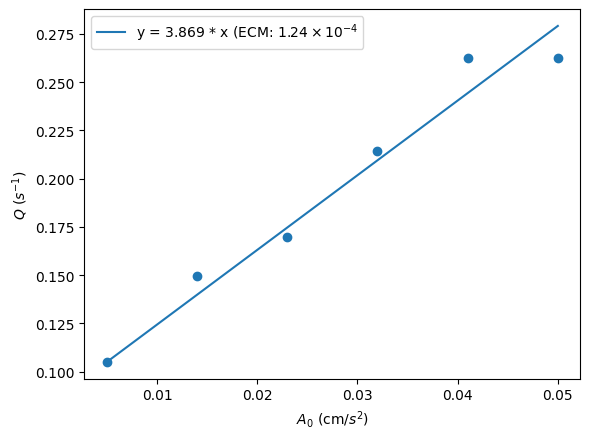

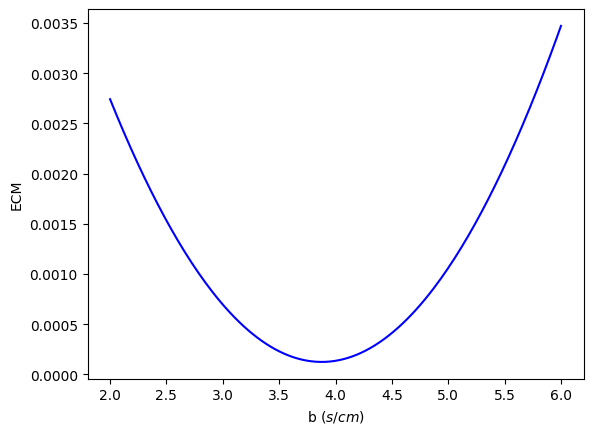

R: 0.2584415584415584


In [42]:
# Graph q_means vs a0 with error bars
plt.scatter(A0_VALUES, q_means)
# plt.errorbar(A0_VALUES, q_means, yerr=q_std, fmt='o')
plt.plot(A0_VALUES, [best_b * (a0 - A0_VALUES[0]) + q_means[0] for a0 in A0_VALUES], label=f"y = {best_b:.3f} * x (ECM: {formatter(min_b_error, None)}")
plt.legend(loc='upper left')
plt.xlabel("$A_0$ (cm/$s^2$)")
plt.ylabel("$Q$ ($s^{-1}$)")

plt.savefig("../analysis/q_vs_a0.png", dpi=300)
plt.show()
plt.clf()

plt.plot(b_possible_vals, errors, color='blue')
plt.xlabel("b ($s/cm$)")
plt.ylabel("ECM")

plt.savefig("../analysis/q_vs_a0_error.png", dpi=300)
plt.show()

# Q = m_p * a0 / R
# b = m_p / R
# R = m_p / b

print(f"R: {1 / best_b}")